In [1]:
# Install transformers if needed
!pip install transformers -q

import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)

# Load your data
df = pd.read_csv("all_fed_paragraphs_v2.csv")

# Sentiment analysis function
def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]

    # FinBERT labels: positive, negative, neutral
    return probs[0], probs[1], probs[2]

# Run on all paragraphs
results = []
for i, row in df.iterrows():
    pos, neg, neu = get_sentiment(row['paragraph_text'])
    results.append({
        'statement_date': row['statement_date'],
        'paragraph_num': row['paragraph_num'],
        'paragraph_text': row['paragraph_text'],
        'positive_score': pos,
        'negative_score': neg,
        'neutral_score': neu,
        'sentiment_label': ['positive', 'negative', 'neutral'][pd.Series([pos, neg, neu]).argmax()]
    })

    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(df)}")

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("fed_sentiment_results.csv", index=False)
print(f"\nDone! Saved {len(results_df)} rows to fed_sentiment_results.csv")

Using: cpu


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processed 50/449
Processed 100/449
Processed 150/449
Processed 200/449
Processed 250/449
Processed 300/449
Processed 350/449
Processed 400/449

Done! Saved 449 rows to fed_sentiment_results.csv


In [2]:
import pandas as pd

df = pd.read_csv("fed_sentiment_results.csv")

print("Sentiment label distribution:")
print(df['sentiment_label'].value_counts())
print()

print("Average scores:")
print(f"  Positive: {df['positive_score'].mean():.3f}")
print(f"  Negative: {df['negative_score'].mean():.3f}")
print(f"  Neutral:  {df['neutral_score'].mean():.3f}")

Sentiment label distribution:
sentiment_label
neutral     387
positive     37
negative     25
Name: count, dtype: int64

Average scores:
  Positive: 0.124
  Negative: 0.087
  Neutral:  0.789


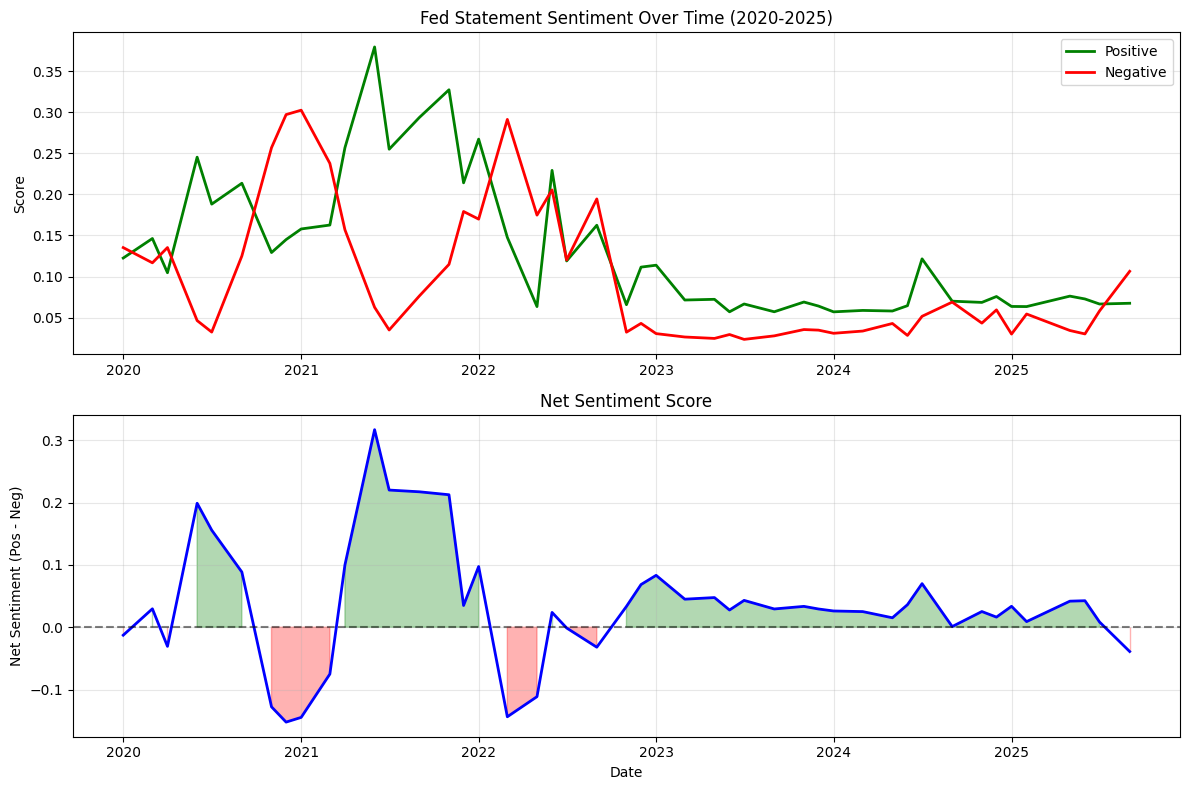

         date  positive_score  negative_score  net_sentiment
0  2020-01-01        0.122483        0.135199      -0.012716
1  2020-03-01        0.146255        0.116670       0.029585
2  2020-04-01        0.104596        0.135250      -0.030654
3  2020-06-01        0.245286        0.046348       0.198938
4  2020-07-01        0.188131        0.032338       0.155793
5  2020-09-01        0.213543        0.124959       0.088584
6  2020-11-01        0.129178        0.256866      -0.127688
7  2020-12-01        0.144960        0.297130      -0.152170
8  2021-01-01        0.157882        0.302499      -0.144617
9  2021-03-01        0.162652        0.237746      -0.075094
10 2021-04-01        0.256831        0.156889       0.099942
11 2021-06-01        0.379489        0.062514       0.316974
12 2021-07-01        0.254984        0.034880       0.220104
13 2021-09-01        0.293585        0.076266       0.217319
14 2021-11-01        0.327338        0.114761       0.212577
15 2021-12-01        0.2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("fed_sentiment_results.csv")

# Parse dates from statement_date
def parse_date(s):
    # Handle special cases like March2020_15, March2020_23
    s = s.split('_')[0]
    months = {'Jan': 1, 'Feb': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
              'July': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    for m, num in months.items():
        if s.startswith(m):
            year = int(s.replace(m, ''))
            return pd.Timestamp(year=year, month=num, day=1)
    return None

df['date'] = df['statement_date'].apply(parse_date)

# Aggregate by statement date
stmt_sentiment = df.groupby('date').agg({
    'positive_score': 'mean',
    'negative_score': 'mean',
    'neutral_score': 'mean'
}).reset_index()

stmt_sentiment['net_sentiment'] = stmt_sentiment['positive_score'] - stmt_sentiment['negative_score']
stmt_sentiment = stmt_sentiment.sort_values('date')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Positive vs Negative over time
axes[0].plot(stmt_sentiment['date'], stmt_sentiment['positive_score'], label='Positive', color='green', linewidth=2)
axes[0].plot(stmt_sentiment['date'], stmt_sentiment['negative_score'], label='Negative', color='red', linewidth=2)
axes[0].set_ylabel('Score')
axes[0].set_title('Fed Statement Sentiment Over Time (2020-2025)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Net sentiment
axes[1].plot(stmt_sentiment['date'], stmt_sentiment['net_sentiment'], color='blue', linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].fill_between(stmt_sentiment['date'], stmt_sentiment['net_sentiment'], 0,
                      where=(stmt_sentiment['net_sentiment'] > 0), color='green', alpha=0.3)
axes[1].fill_between(stmt_sentiment['date'], stmt_sentiment['net_sentiment'], 0,
                      where=(stmt_sentiment['net_sentiment'] < 0), color='red', alpha=0.3)
axes[1].set_ylabel('Net Sentiment (Pos - Neg)')
axes[1].set_xlabel('Date')
axes[1].set_title('Net Sentiment Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fed_sentiment_over_time.png', dpi=150)
plt.show()

print(stmt_sentiment[['date', 'positive_score', 'negative_score', 'net_sentiment']].to_string())

1. OVERALL SUMMARY STATISTICS

Total paragraphs: 449
Total statements: 48

Sentiment label distribution:
sentiment_label
neutral     387
positive     37
negative     25
Name: count, dtype: int64

Score statistics:
       positive_score  negative_score  neutral_score  net_sentiment
count      449.000000      449.000000     449.000000     449.000000
mean         0.123991        0.086820       0.789189       0.037171
std          0.184270        0.184634       0.262344       0.259357
min          0.009699        0.008664       0.020469      -0.955760
25%          0.038635        0.018177       0.840163      -0.006276
50%          0.046677        0.024600       0.912520       0.024772
75%          0.115662        0.058717       0.933231       0.057541
max          0.903383        0.965459       0.951094       0.832688

2. MOST POSITIVE PARAGRAPHS

July2021 (para 1) - Positive: 0.903
   The Federal Reserve is committed to using its full range of tools to support the U.S. economy in this cha

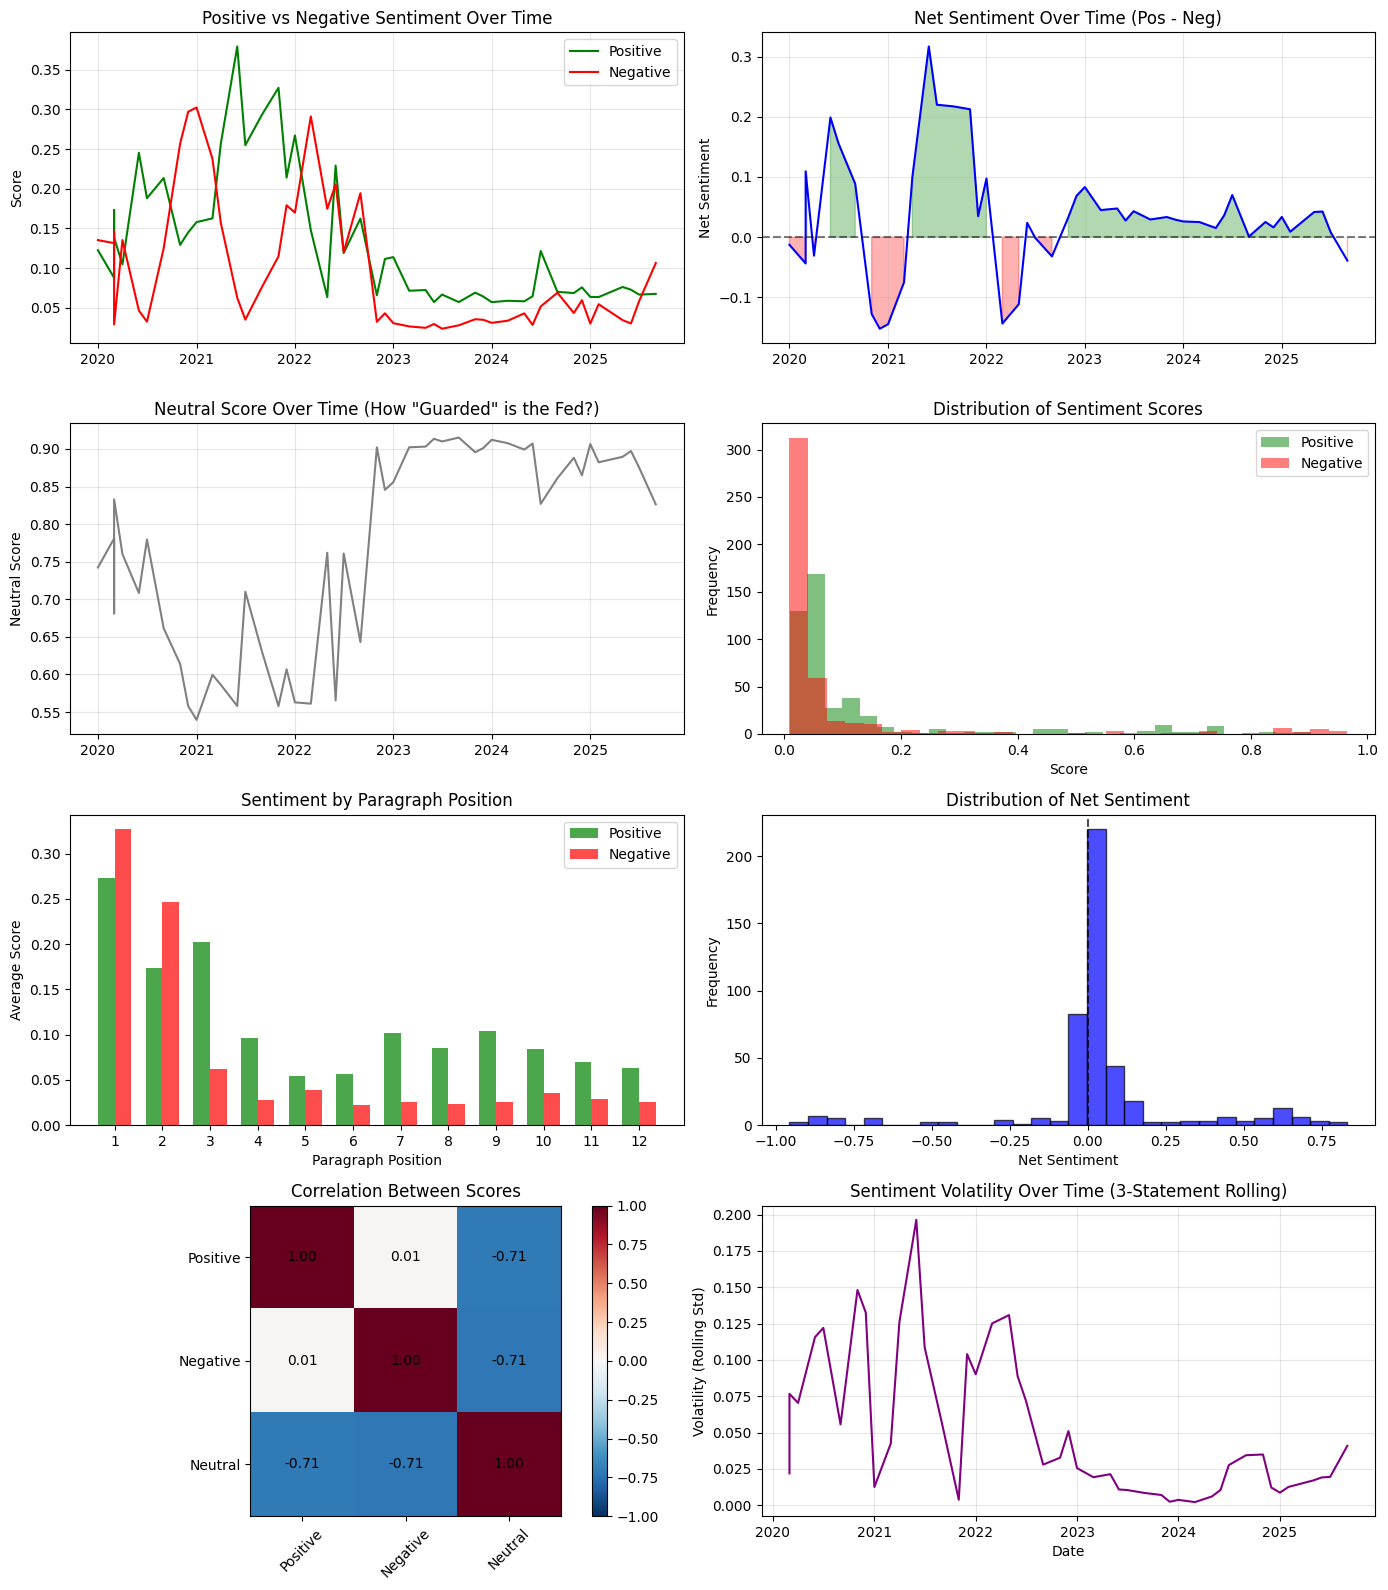


5. KEY PERIODS ANALYSIS

COVID Period (Mar-Jun 2020):
  Avg Net Sentiment: 0.052
  Avg Neutral: 0.753

Inflation Period (2022):
  Avg Net Sentiment: -0.008
  Avg Neutral: 0.700

Recent Period (2024-2025):
  Avg Net Sentiment: 0.022
  Avg Neutral: 0.882

EDA COMPLETE - Check fed_sentiment_eda.png


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("fed_sentiment_results.csv")

# Parse dates
def parse_date(s):
    s = s.split('_')[0]
    months = {'Jan': 1, 'Feb': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
              'July': 7, 'Aug': 8, 'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    for m, num in months.items():
        if s.startswith(m):
            year = int(s.replace(m, ''))
            return pd.Timestamp(year=year, month=num, day=1)
    return None

df['date'] = df['statement_date'].apply(parse_date)
df['net_sentiment'] = df['positive_score'] - df['negative_score']

# =============================================================================
# 1. OVERALL SUMMARY STATS
# =============================================================================
print("="*60)
print("1. OVERALL SUMMARY STATISTICS")
print("="*60)
print(f"\nTotal paragraphs: {len(df)}")
print(f"Total statements: {df['statement_date'].nunique()}")
print(f"\nSentiment label distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nScore statistics:")
print(df[['positive_score', 'negative_score', 'neutral_score', 'net_sentiment']].describe())

# =============================================================================
# 2. MOST POSITIVE AND NEGATIVE PARAGRAPHS
# =============================================================================
print("\n" + "="*60)
print("2. MOST POSITIVE PARAGRAPHS")
print("="*60)
top_positive = df.nlargest(5, 'positive_score')[['statement_date', 'paragraph_num', 'positive_score', 'paragraph_text']]
for _, row in top_positive.iterrows():
    print(f"\n{row['statement_date']} (para {row['paragraph_num']}) - Positive: {row['positive_score']:.3f}")
    print(f"   {row['paragraph_text'][:150]}...")

print("\n" + "="*60)
print("3. MOST NEGATIVE PARAGRAPHS")
print("="*60)
top_negative = df.nlargest(5, 'negative_score')[['statement_date', 'paragraph_num', 'negative_score', 'paragraph_text']]
for _, row in top_negative.iterrows():
    print(f"\n{row['statement_date']} (para {row['paragraph_num']}) - Negative: {row['negative_score']:.3f}")
    print(f"   {row['paragraph_text'][:150]}...")

# =============================================================================
# 4. SENTIMENT BY PARAGRAPH POSITION
# =============================================================================
print("\n" + "="*60)
print("4. SENTIMENT BY PARAGRAPH POSITION")
print("="*60)
position_sentiment = df.groupby('paragraph_num').agg({
    'positive_score': 'mean',
    'negative_score': 'mean',
    'neutral_score': 'mean',
    'net_sentiment': 'mean'
}).reset_index()
print(position_sentiment.head(10).to_string(index=False))

# =============================================================================
# 5. AGGREGATE BY STATEMENT DATE FOR TIME SERIES
# =============================================================================
stmt_sentiment = df.groupby(['date', 'statement_date']).agg({
    'positive_score': 'mean',
    'negative_score': 'mean',
    'neutral_score': 'mean',
    'net_sentiment': 'mean'
}).reset_index().sort_values('date')

# =============================================================================
# PLOTTING
# =============================================================================
fig = plt.figure(figsize=(14, 16))

# Plot 1: Sentiment over time
ax1 = fig.add_subplot(4, 2, 1)
ax1.plot(stmt_sentiment['date'], stmt_sentiment['positive_score'], label='Positive', color='green', linewidth=1.5)
ax1.plot(stmt_sentiment['date'], stmt_sentiment['negative_score'], label='Negative', color='red', linewidth=1.5)
ax1.set_ylabel('Score')
ax1.set_title('Positive vs Negative Sentiment Over Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Net sentiment over time
ax2 = fig.add_subplot(4, 2, 2)
ax2.plot(stmt_sentiment['date'], stmt_sentiment['net_sentiment'], color='blue', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.fill_between(stmt_sentiment['date'], stmt_sentiment['net_sentiment'], 0,
                  where=(stmt_sentiment['net_sentiment'] > 0), color='green', alpha=0.3)
ax2.fill_between(stmt_sentiment['date'], stmt_sentiment['net_sentiment'], 0,
                  where=(stmt_sentiment['net_sentiment'] < 0), color='red', alpha=0.3)
ax2.set_ylabel('Net Sentiment')
ax2.set_title('Net Sentiment Over Time (Pos - Neg)')
ax2.grid(True, alpha=0.3)

# Plot 3: Neutral score over time
ax3 = fig.add_subplot(4, 2, 3)
ax3.plot(stmt_sentiment['date'], stmt_sentiment['neutral_score'], color='gray', linewidth=1.5)
ax3.set_ylabel('Neutral Score')
ax3.set_title('Neutral Score Over Time (How "Guarded" is the Fed?)')
ax3.grid(True, alpha=0.3)

# Plot 4: Score distributions
ax4 = fig.add_subplot(4, 2, 4)
ax4.hist(df['positive_score'], bins=30, alpha=0.5, label='Positive', color='green')
ax4.hist(df['negative_score'], bins=30, alpha=0.5, label='Negative', color='red')
ax4.set_xlabel('Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Sentiment Scores')
ax4.legend()

# Plot 5: Sentiment by paragraph position
ax5 = fig.add_subplot(4, 2, 5)
positions = position_sentiment[position_sentiment['paragraph_num'] <= 12]
x = positions['paragraph_num']
width = 0.35
ax5.bar(x - width/2, positions['positive_score'], width, label='Positive', color='green', alpha=0.7)
ax5.bar(x + width/2, positions['negative_score'], width, label='Negative', color='red', alpha=0.7)
ax5.set_xlabel('Paragraph Position')
ax5.set_ylabel('Average Score')
ax5.set_title('Sentiment by Paragraph Position')
ax5.legend()
ax5.set_xticks(x)

# Plot 6: Net sentiment distribution
ax6 = fig.add_subplot(4, 2, 6)
ax6.hist(df['net_sentiment'], bins=30, color='blue', alpha=0.7, edgecolor='black')
ax6.axvline(x=0, color='black', linestyle='--', alpha=0.7)
ax6.set_xlabel('Net Sentiment')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Net Sentiment')

# Plot 7: Correlation heatmap
ax7 = fig.add_subplot(4, 2, 7)
corr_cols = ['positive_score', 'negative_score', 'neutral_score']
corr_matrix = df[corr_cols].corr()
im = ax7.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
ax7.set_xticks(range(len(corr_cols)))
ax7.set_yticks(range(len(corr_cols)))
ax7.set_xticklabels(['Positive', 'Negative', 'Neutral'], rotation=45)
ax7.set_yticklabels(['Positive', 'Negative', 'Neutral'])
for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        ax7.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center')
ax7.set_title('Correlation Between Scores')
plt.colorbar(im, ax=ax7)

# Plot 8: Rolling volatility of sentiment
ax8 = fig.add_subplot(4, 2, 8)
stmt_sentiment['sentiment_volatility'] = stmt_sentiment['net_sentiment'].rolling(window=3, min_periods=1).std()
ax8.plot(stmt_sentiment['date'], stmt_sentiment['sentiment_volatility'], color='purple', linewidth=1.5)
ax8.set_xlabel('Date')
ax8.set_ylabel('Volatility (Rolling Std)')
ax8.set_title('Sentiment Volatility Over Time (3-Statement Rolling)')
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fed_sentiment_eda.png', dpi=150)
plt.show()

# =============================================================================
# 6. KEY EVENTS ANALYSIS
# =============================================================================
print("\n" + "="*60)
print("5. KEY PERIODS ANALYSIS")
print("="*60)

# COVID period (March-June 2020)
covid = stmt_sentiment[(stmt_sentiment['date'] >= '2020-03-01') & (stmt_sentiment['date'] <= '2020-06-30')]
print(f"\nCOVID Period (Mar-Jun 2020):")
print(f"  Avg Net Sentiment: {covid['net_sentiment'].mean():.3f}")
print(f"  Avg Neutral: {covid['neutral_score'].mean():.3f}")

# Inflation period (2022)
inflation = stmt_sentiment[(stmt_sentiment['date'] >= '2022-01-01') & (stmt_sentiment['date'] <= '2022-12-31')]
print(f"\nInflation Period (2022):")
print(f"  Avg Net Sentiment: {inflation['net_sentiment'].mean():.3f}")
print(f"  Avg Neutral: {inflation['neutral_score'].mean():.3f}")

# Recent period (2024-2025)
recent = stmt_sentiment[(stmt_sentiment['date'] >= '2024-01-01')]
print(f"\nRecent Period (2024-2025):")
print(f"  Avg Net Sentiment: {recent['net_sentiment'].mean():.3f}")
print(f"  Avg Neutral: {recent['neutral_score'].mean():.3f}")

print("\n" + "="*60)
print("EDA COMPLETE - Check fed_sentiment_eda.png")
print("="*60)